In [1]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance tensorflow.keras


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import os
import yfinance as yf
warnings.filterwarnings("ignore")


2025-04-20 22:10:10.406322: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 22:10:10.409578: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 22:10:10.422153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745187010.439078    4190 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745187010.445360    4190 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745187010.467926    4190 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")



def run_backtest(df, freq='h',name=""):

  
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  
  
  df['strategy_return'] = df['signal'] * df['return_forward']

  
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  
  
  
  
  
  
  
  

  
  
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [4]:
merged_df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [5]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [6]:
merged_df.drop(columns=['target'], inplace=True)

In [ ]:
train_start_date = pd.to_datetime("2021-01-01 10:00:00")
train_end_date = pd.to_datetime("2023-12-31 23:00:00")

test_start_date = pd.to_datetime("2024-01-01 00:00:00")
test_end_date = pd.to_datetime("2024-12-31 23:00:00")



price_indicator_train = merged_df.loc[train_start_date:train_end_date]
price_indicator_train_X = price_indicator_train.drop("return_forward",axis=1)
price_indicator_train_Y = price_indicator_train["return_forward"]

price_indicator_test = merged_df.loc[test_start_date:test_end_date]
price_indicator_test_X = price_indicator_test.drop("return_forward",axis=1)
price_indicator_test_Y = price_indicator_test["return_forward"]

price_indicator_test


,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2024-01-01 00:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.001385,143.55,210.51,...,1,1,1,0,1,0,0.071577,0.097778,0.003539,0.010173
2024-01-01 01:00:00,1.0,-0.300000,0.000000,0.000000,0.000000,0.200000,0.0,-0.000729,151.35,210.81,...,1,0,1,0,1,0,0.047718,0.089956,0.002359,0.009359
2024-01-01 02:00:00,3.0,-0.233333,0.000000,-0.066667,0.000000,0.333333,0.0,-0.005929,120.60,219.66,...,1,0,1,1,1,0,0.249945,0.135111,0.028840,0.015154
2024-01-01 03:00:00,4.0,0.250000,0.000000,-0.500000,0.000000,-0.175000,0.0,0.000095,43.45,223.39,...,1,0,1,1,1,0,0.166630,0.124302,0.019226,0.013942
2024-01-01 04:00:00,2.0,0.000000,0.000000,-0.450000,0.000000,0.150000,0.0,0.005017,-37.10,221.12,...,1,0,1,1,1,1,0.111087,0.114358,0.012818,0.012827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.0,0.342857,0.157143,0.114286,0.014286,0.471429,0.0,-0.006308,339.30,312.86,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.216667,0.016667,0.083333,0.000000,0.483333,0.0,0.002858,-30.20,309.90,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,0.100000,0.233333,0.200000,0.000000,0.300000,0.0,-0.004142,-238.45,313.73,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.200000,0.200000,0.475000,0.000000,0.925000,0.0,0.000933,-365.30,310.76,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441


In [8]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


with open('./pickles/hybrid_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/hybrid_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/hybrid_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [10]:
print(selected_features)

['target', 'atr_7', 'trailing_stop_long_7', '10_band_width', '20_band_width', 'pct_b_10', 'sma_50_200_diff', 'reddit_total_sentiment_ewm_5h', 'rsi_7_acceleration', 'adx', 'sma_20_50_diff', 'tanalysis_absa_ewm_12h', 'sma_50_200_diff_pct_chg', 'reddit_total_sentiment_ewm_24h', 'sma_5_20_diff_pct_chg']


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)


y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))


sequence_length = 12  


X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])


X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)


print(f"X shape: {X_sequences.shape}")  
print(f"y shape: {y_sequences.shape}")  



X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


best_lstm_params = {
    'batch_size': 128, 
    'dropout_rate': np.float64(0.34474115788895177),
    'learning_rate': np.float64(0.00019010245319870352),
    'lstm_units': 64,
    'n_lstm_layers': 2
}


n_layers = best_lstm_params['n_lstm_layers']
units = best_lstm_params['lstm_units']
dropout = best_lstm_params['dropout_rate']
lr = best_lstm_params['learning_rate']




N_TIMESTEPS = X_train.shape[1] 
N_FEATURES = X_train.shape[2]   
num_samples = X_train.shape[0]



print("Building LSTM model with the following parameters:")
print(f"- LSTM Layers: {n_layers}")
print(f"- LSTM Units: {units}")
print(f"- Dropout Rate: {dropout:.4f}")
print(f"- Learning Rate: {lr:.6f}")
print(f"- Input Shape: ({N_TIMESTEPS}, {N_FEATURES})")
print("-" * 30)

model = Sequential(name=f"Optimized_LSTM_{n_layers}Layer_Reg")
model.add(Input(shape=(N_TIMESTEPS, N_FEATURES), name="Input_Layer"))


for i in range(n_layers):
    is_last_lstm_layer = (i == n_layers - 1)
    return_sequences = not is_last_lstm_layer 

    model.add(LSTM(units=units,
                              dropout=dropout,          
                              recurrent_dropout=dropout,
                              return_sequences=return_sequences,
                              name=f"LSTM_{i+1}"))


model.add(Dropout(dropout, name="Final_Dropout"))


model.add(Dense(1, activation='linear', name="Output_Layer"))



optimizer = Adam(learning_rate=lr)

model.compile(loss='mean_squared_error', 
                         optimizer=optimizer,
                         metrics=['mae', 'mse'])    


model.summary()

print("\nModel 'model' is built and compiled.")
print(f"Remember to use batch_size={best_lstm_params['batch_size']} during training (model.fit).")


early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=15,          
    restore_best_weights=True, 
    verbose=1             
)


N_EPOCHS = 150
X_train_reshaped = X_train.reshape(num_samples, N_TIMESTEPS * N_FEATURES)
X_test_reshaped = X_test.reshape(X_test.shape[0], N_TIMESTEPS * N_FEATURES)




history = model.fit(
    X_train, y_train,
    
    batch_size=best_lstm_params['batch_size'],
    epochs=N_EPOCHS,
    validation_split=0.2, 
    callbacks=[early_stopping],
    shuffle=True,         
    verbose=1             
)

print("\nTraining finished.")


print("\nEvaluating the final model on the test set...")


test_evaluation_results = model.evaluate(
    X_test, y_test,
    batch_size=best_lstm_params['batch_size'], 
    verbose=0 
)
test_evaluation_results

predictions = model.predict(X_test, batch_size=best_lstm_params['batch_size'])
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

predictions

Building LSTM model with the following parameters:
- LSTM Layers: 2
- LSTM Units: 64
- Dropout Rate: 0.3447
- Learning Rate: 0.000190
- Input Shape: (12, 15)
------------------------------


2025-04-20 22:10:16.702680: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "Optimized_LSTM_2Layer_Reg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 12, 64)         │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Final_Dropout (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)


Model 'model' is built and compiled.
Remember to use batch_size=128 during training (model.fit).
Epoch 1/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0758 - mae: 0.2165 - mse: 0.0758 - val_loss: 8.4600e-04 - val_mae: 0.0229 - val_mse: 8.4600e-04
Epoch 2/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0176 - mae: 0.1059 - mse: 0.0176 - val_loss: 4.6686e-04 - val_mae: 0.0161 - val_mse: 4.6686e-04
Epoch 3/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0117 - mae: 0.0866 - mse: 0.0117 - val_loss: 3.8137e-04 - val_mae: 0.0145 - val_mse: 3.8137e-04
Epoch 4/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0085 - mae: 0.0734 - mse: 0.0085 - val_loss: 3.0758e-04 - val_mae: 0.0122 - val_mse: 3.0758e-04
Epoch 5/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0068 - mae: 0.0648 - mse: 0.0068 - val_loss: 3.6138e-04 - val_mae: 0.0141 - val_mse: 3.6138e-04
Epoch 6/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0059 - mae: 0.0607 - mse: 0.0059 - va

array([[ 0.00010251],
       [ 0.00012753],
       [ 0.00012404],
       ...,
       [-0.00017119],
       [-0.00017268],
       [-0.0001604 ]], dtype=float32)

In [ ]:
model.save('lstm_mse.keras')  


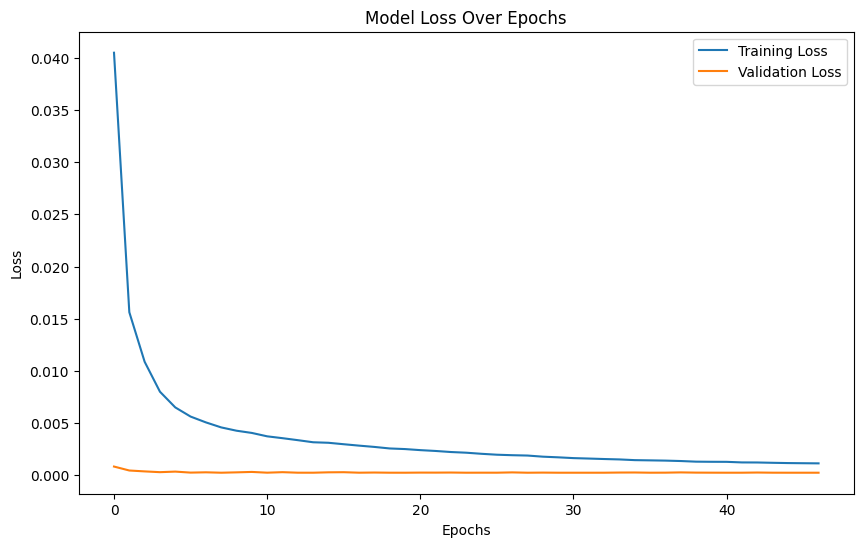

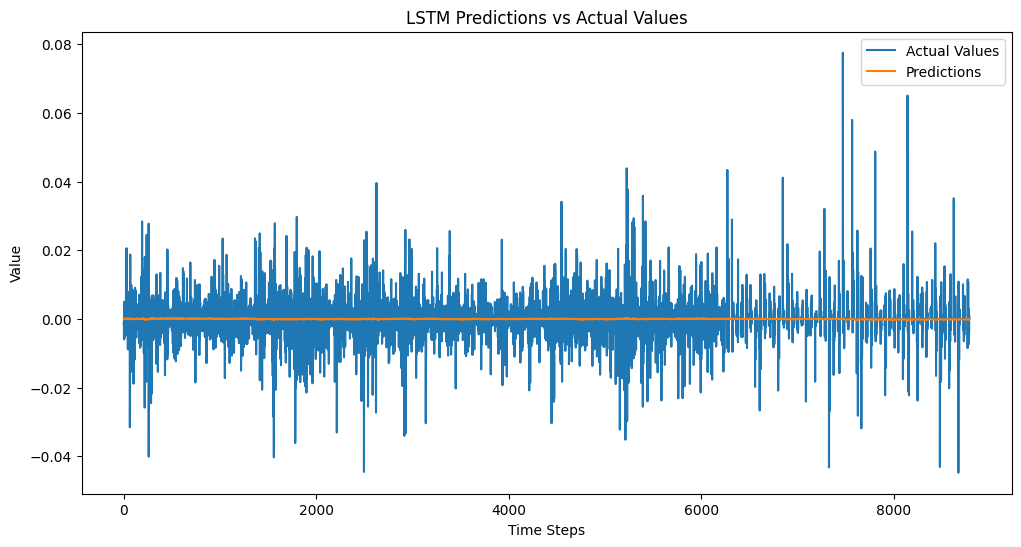

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('lstm_mse.keras')  
predictions = model.predict(X_test, batch_size=best_lstm_params['batch_size'])
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)





results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted']
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < -0.0001 else 0))
stat_signal_result_df['target'] = df["target"]-1

stat_signal_result_df

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


,Actual,Predicted,signal,target
2024-01-01 00:00:00,-0.001385,0.000103,1,-1
2024-01-01 01:00:00,-0.000729,0.000128,1,0
2024-01-01 02:00:00,-0.005929,0.000124,1,-1
2024-01-01 03:00:00,0.000095,0.000133,1,0
2024-01-01 04:00:00,0.005017,0.000112,1,1
...,...,...,...,...
2024-12-31 19:00:00,-0.006308,-0.000151,-1,-1
2024-12-31 20:00:00,0.002858,-0.000162,-1,1
2024-12-31 21:00:00,-0.004142,-0.000171,-1,-1
2024-12-31 22:00:00,0.000933,-0.000173,-1,0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']



accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")


print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) 

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.3221
Precision (Weighted): 0.3238
Recall (Weighted): 0.3221
F1 Score (Weighted): 0.2582
\nMetrics per class:
  Class -1:
    Precision: 0.1979
    Recall:    0.1020
    F1 Score:  0.1346
  Class 0:
    Precision: 0.3380
    Recall:    0.7049
    F1 Score:  0.4569
  Class 1:
    Precision: 0.4240
    Recall:    0.0877
    F1 Score:  0.1453


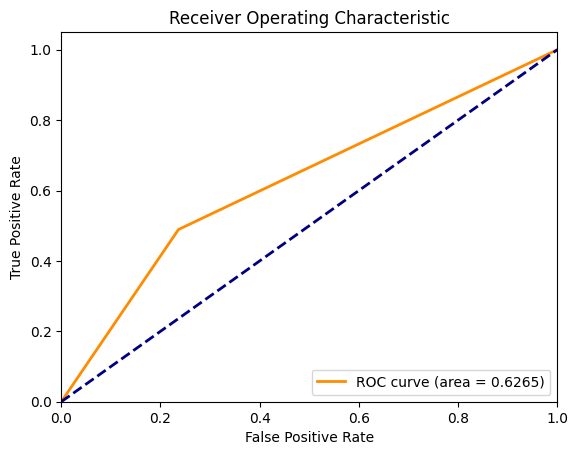

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score



mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]



y_true_binary = np.where(y_true_filtered == 1, 1, 0)


fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)


roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: 30.96%
Overall Annual Sharpe Ratio: 1.1119
Maximum Drawdown: -15.37 %
Alpha: 0.4832
Beta: -0.0926

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.309595    0.277052    -0.092564      0.394208       1.111856


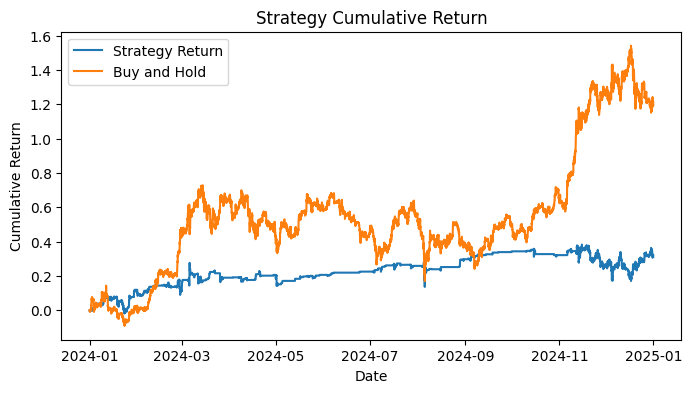

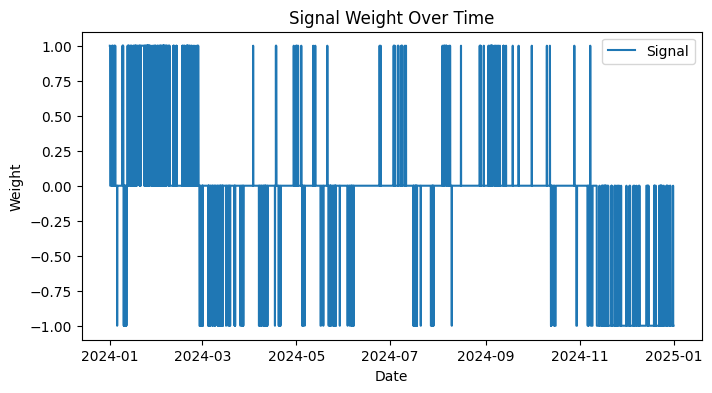

In [18]:
run_backtest(stat_signal_result_df, name ="LSTM_MSE_Hybrid")

In [19]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


with open('./pickles/hybrid_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/hybrid_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/hybrid_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [21]:
print(selected_features)

['target', 'atr_7', 'trailing_stop_long_7', '10_band_width', '20_band_width', 'pct_b_10', 'sma_50_200_diff', 'reddit_total_sentiment_ewm_5h', 'rsi_7_acceleration', 'adx', 'sma_20_50_diff', 'tanalysis_absa_ewm_12h', 'sma_50_200_diff_pct_chg', 'reddit_total_sentiment_ewm_24h', 'sma_5_20_diff_pct_chg']


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)


y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))


sequence_length = 12  


X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])


X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)


print(f"X shape: {X_sequences.shape}")  
print(f"y shape: {y_sequences.shape}")  



X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from keras.saving import register_keras_serializable

@register_keras_serializable(package="Custom", name="directional_penalty_loss")
def directional_penalty_loss(y_true, y_pred):
    """
    Custom loss function that penalizes incorrect directional predictions more heavily.
    It combines Mean Squared Error (MSE) with an additional penalty if the predicted
    direction (sign) is different from the true direction.

    Args:
        y_true: True target values (actual returns).
        y_pred: Predicted values (predicted returns).

    Returns:
        A scalar tensor representing the calculated loss.
    """
    
    mse_loss = K.mean(K.square(y_true - y_pred), axis=-1)

    
    
    wrong_direction = K.not_equal(tf.sign(y_true), tf.sign(y_pred))
    
    
    directional_penalty_mask = tf.cast(wrong_direction, K.floatx())

    
    
    penalty_magnitude = 0.1 

    
    directional_penalty = K.mean(directional_penalty_mask * penalty_magnitude, axis=-1)

    
    total_loss = mse_loss + directional_penalty
    
    return total_loss


best_lstm_params = {
    'batch_size': 128, 
    'dropout_rate': np.float64(0.34474115788895177),
    'learning_rate': np.float64(0.00019010245319870352),
    'lstm_units': 64,
    'n_lstm_layers': 2
}


n_layers = best_lstm_params['n_lstm_layers']
units = best_lstm_params['lstm_units']
dropout = best_lstm_params['dropout_rate']
lr = best_lstm_params['learning_rate']




N_TIMESTEPS = X_train.shape[1] 
N_FEATURES = X_train.shape[2]   
num_samples = X_train.shape[0]



print("Building LSTM model with the following parameters:")
print(f"- LSTM Layers: {n_layers}")
print(f"- LSTM Units: {units}")
print(f"- Dropout Rate: {dropout:.4f}")
print(f"- Learning Rate: {lr:.6f}")
print(f"- Input Shape: ({N_TIMESTEPS}, {N_FEATURES})")
print("-" * 30)

model = Sequential(name=f"Optimized_LSTM_{n_layers}Layer_Reg")
model.add(Input(shape=(N_TIMESTEPS, N_FEATURES), name="Input_Layer"))


for i in range(n_layers):
    is_last_lstm_layer = (i == n_layers - 1)
    return_sequences = not is_last_lstm_layer 

    model.add(LSTM(units=units,
                              dropout=dropout,          
                              recurrent_dropout=dropout,
                              return_sequences=return_sequences,
                              name=f"LSTM_{i+1}"))


model.add(Dropout(dropout, name="Final_Dropout"))


model.add(Dense(1, activation='linear', name="Output_Layer"))



optimizer = Adam(learning_rate=lr)

model.compile(loss=directional_penalty_loss, 
                         optimizer=optimizer,
                         metrics=['mae', 'mse'])    


model.summary()

print("\nModel 'model' is built and compiled.")
print(f"Remember to use batch_size={best_lstm_params['batch_size']} during training (model.fit).")


early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=15,          
    restore_best_weights=True, 
    verbose=1             
)


N_EPOCHS = 150
X_train_reshaped = X_train.reshape(num_samples, N_TIMESTEPS * N_FEATURES)
X_test_reshaped = X_test.reshape(X_test.shape[0], N_TIMESTEPS * N_FEATURES)




history = model.fit(
    X_train, y_train,
    
    batch_size=best_lstm_params['batch_size'],
    epochs=N_EPOCHS,
    validation_split=0.2, 
    callbacks=[early_stopping],
    shuffle=True,         
    verbose=1             
)

print("\nTraining finished.")


print("\nEvaluating the final model on the test set...")


test_evaluation_results = model.evaluate(
    X_test, y_test,
    batch_size=best_lstm_params['batch_size'], 
    verbose=0 
)
test_evaluation_results

predictions = model.predict(X_test, batch_size=best_lstm_params['batch_size'])
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

predictions

Building LSTM model with the following parameters:
- LSTM Layers: 2
- LSTM Units: 64
- Dropout Rate: 0.3447
- Learning Rate: 0.000190
- Input Shape: (12, 15)
------------------------------


Model: "Optimized_LSTM_2Layer_Reg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 12, 64)         │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Final_Dropout (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)


Model 'model' is built and compiled.
Remember to use batch_size=128 during training (model.fit).
Epoch 1/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0730 - mae: 0.2069 - mse: 0.0677 - val_loss: 7.3619e-04 - val_mae: 0.0200 - val_mse: 7.3619e-04
Epoch 2/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0165 - mae: 0.1022 - mse: 0.0165 - val_loss: 4.3153e-04 - val_mae: 0.0151 - val_mse: 4.3153e-04
Epoch 3/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0106 - mae: 0.0823 - mse: 0.0106 - val_loss: 3.1900e-04 - val_mae: 0.0122 - val_mse: 3.1900e-04
Epoch 4/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0079 - mae: 0.0710 - mse: 0.0079 - val_loss: 2.8868e-04 - val_mae: 0.0114 - val_mse: 2.8868e-04
Epoch 5/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0064 - mae: 0.0631 - mse: 0.0064 - val_loss: 2.7895e-04 - val_mae: 0.0110 - val_mse: 2.7895e-04
Epoch 6/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0057 - mae: 0.0592 - mse: 0.0057 - val

array([[ 7.07174549e-05],
       [ 8.65272086e-05],
       [ 8.80006264e-05],
       ...,
       [-1.18969865e-05],
       [-1.99713068e-05],
       [-1.95587509e-05]], dtype=float32)

In [ ]:
model.save('lstm_dl.keras')  


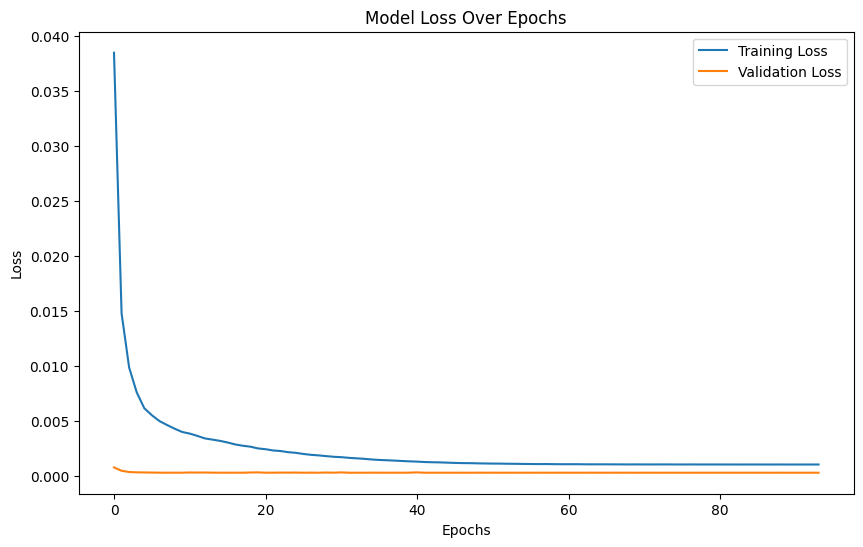

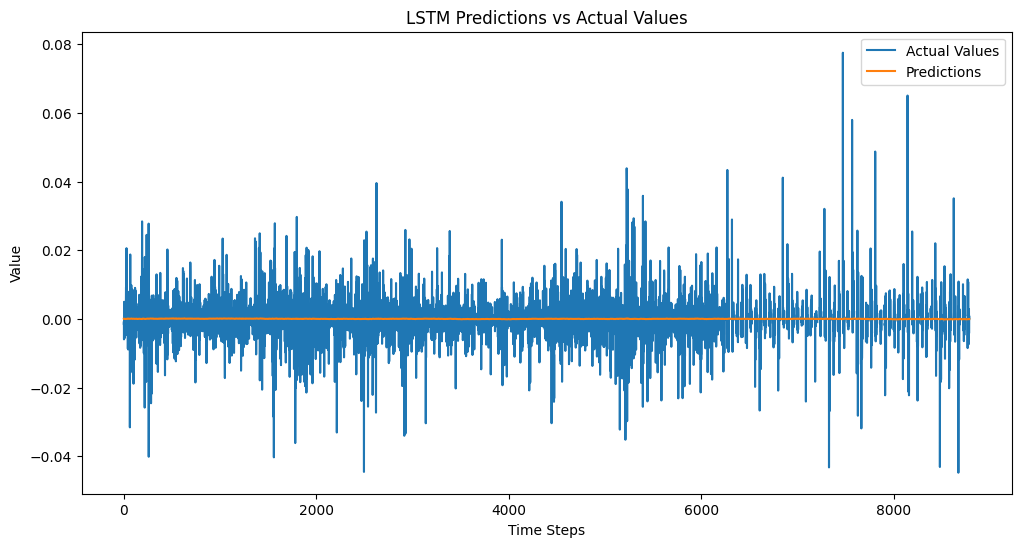

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('lstm_dl.keras')  
predictions = model.predict(X_test, batch_size=best_lstm_params['batch_size'])
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)





results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.00001 else (-1 if x < -0.00001 else 0))
stat_signal_result_df['target'] = df["target"]-1

stat_signal_result_df

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


,Actual,Predicted,signal,target
2024-01-01 00:00:00,-0.001385,0.000071,1,-1
2024-01-01 01:00:00,-0.000729,0.000087,1,0
2024-01-01 02:00:00,-0.005929,0.000088,1,-1
2024-01-01 03:00:00,0.000095,0.000088,1,0
2024-01-01 04:00:00,0.005017,0.000087,1,1
...,...,...,...,...
2024-12-31 19:00:00,-0.006308,-0.000008,0,-1
2024-12-31 20:00:00,0.002858,-0.000013,-1,1
2024-12-31 21:00:00,-0.004142,-0.000012,-1,-1
2024-12-31 22:00:00,0.000933,-0.000020,-1,0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']



accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")


print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) 

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.3412
Precision (Weighted): 0.3439
Recall (Weighted): 0.3412
F1 Score (Weighted): 0.2848
\nMetrics per class:
  Class -1:
    Precision: 0.2267
    Recall:    0.1288
    F1 Score:  0.1643
  Class 0:
    Precision: 0.4297
    Recall:    0.1362
    F1 Score:  0.2069
  Class 1:
    Precision: 0.3541
    Recall:    0.7722
    F1 Score:  0.4855


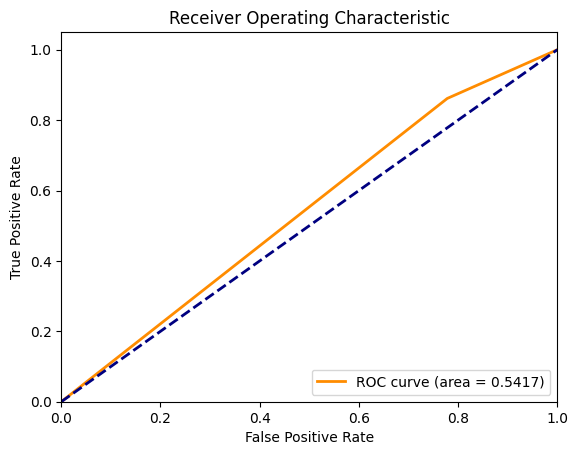

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score



mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]



y_true_binary = np.where(y_true_filtered == 1, 1, 0)


fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)


roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: 53.85%
Overall Annual Sharpe Ratio: 1.1085
Maximum Drawdown: -34.41 %
Alpha: -0.0245
Beta: 0.6252

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.538461    0.502609      0.62519     -0.024848       1.108484


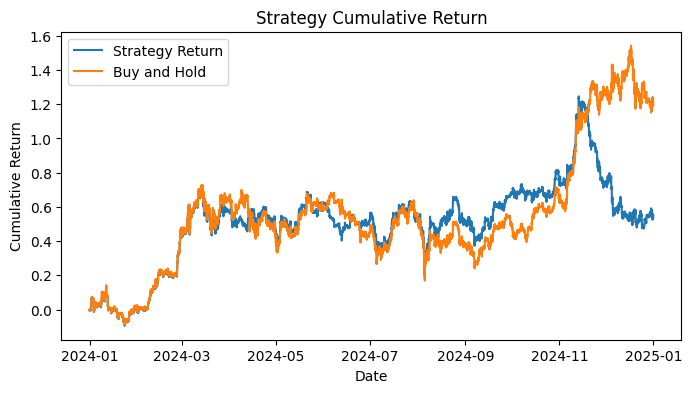

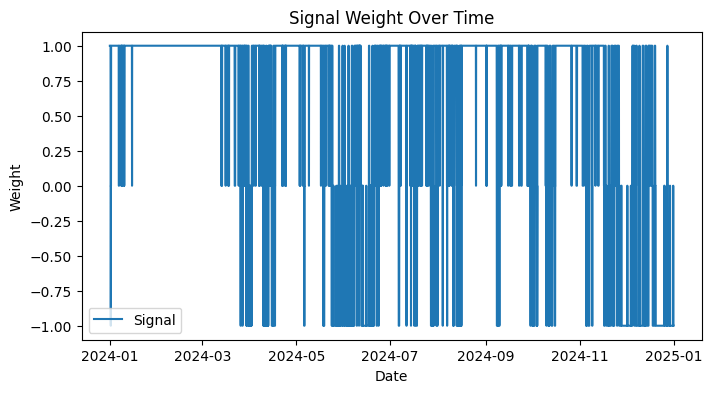

In [33]:
run_backtest(stat_signal_result_df, name ="lstm_Directional_Hybrid")

In [34]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


with open('./pickles/hybrid_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/hybrid_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/hybrid_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [36]:
print(selected_features)

['target', 'atr_7', 'trailing_stop_long_7', '10_band_width', '20_band_width', 'pct_b_10', 'sma_50_200_diff', 'reddit_total_sentiment_ewm_5h', 'rsi_7_acceleration', 'adx', 'sma_20_50_diff', 'tanalysis_absa_ewm_12h', 'sma_50_200_diff_pct_chg', 'reddit_total_sentiment_ewm_24h', 'sma_5_20_diff_pct_chg']


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)


y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))


sequence_length = 12  


X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])


X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)


print(f"X shape: {X_sequences.shape}")  
print(f"y shape: {y_sequences.shape}")  



X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from keras.saving import register_keras_serializable

@register_keras_serializable(package="Custom", name="weighted_loss")
def weighted_loss(y_true, y_pred):
    
    returns = y_pred - y_true
    
    
    positive_weight = 0.5
    negative_weight = 1.5
    
    
    loss = K.mean(K.switch(returns > 0, positive_weight * K.square(returns), negative_weight * K.square(returns)))
    
    return loss


best_lstm_params = {
    'batch_size': 128, 
    'dropout_rate': np.float64(0.34474115788895177),
    'learning_rate': np.float64(0.00019010245319870352),
    'lstm_units': 64,
    'n_lstm_layers': 2
}


n_layers = best_lstm_params['n_lstm_layers']
units = best_lstm_params['lstm_units']
dropout = best_lstm_params['dropout_rate']
lr = best_lstm_params['learning_rate']




N_TIMESTEPS = X_train.shape[1] 
N_FEATURES = X_train.shape[2]   
num_samples = X_train.shape[0]



print("Building LSTM model with the following parameters:")
print(f"- LSTM Layers: {n_layers}")
print(f"- LSTM Units: {units}")
print(f"- Dropout Rate: {dropout:.4f}")
print(f"- Learning Rate: {lr:.6f}")
print(f"- Input Shape: ({N_TIMESTEPS}, {N_FEATURES})")
print("-" * 30)

model = Sequential(name=f"Optimized_LSTM_{n_layers}Layer_Reg")
model.add(Input(shape=(N_TIMESTEPS, N_FEATURES), name="Input_Layer"))


for i in range(n_layers):
    is_last_lstm_layer = (i == n_layers - 1)
    return_sequences = not is_last_lstm_layer 

    model.add(LSTM(units=units,
                              dropout=dropout,          
                              recurrent_dropout=dropout,
                              return_sequences=return_sequences,
                              name=f"LSTM_{i+1}"))


model.add(Dropout(dropout, name="Final_Dropout"))


model.add(Dense(1, activation='linear', name="Output_Layer"))



optimizer = Adam(learning_rate=lr)

model.compile(loss=weighted_loss, 
                         optimizer=optimizer,
                         metrics=['mae', 'mse'])    


model.summary()

print("\nModel 'model' is built and compiled.")
print(f"Remember to use batch_size={best_lstm_params['batch_size']} during training (model.fit).")


early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=15,          
    restore_best_weights=True, 
    verbose=1             
)


N_EPOCHS = 150
X_train_reshaped = X_train.reshape(num_samples, N_TIMESTEPS * N_FEATURES)
X_test_reshaped = X_test.reshape(X_test.shape[0], N_TIMESTEPS * N_FEATURES)




history = model.fit(
    X_train, y_train,
    
    batch_size=best_lstm_params['batch_size'],
    epochs=N_EPOCHS,
    validation_split=0.2, 
    callbacks=[early_stopping],
    shuffle=True,         
    verbose=1             
)

print("\nTraining finished.")


print("\nEvaluating the final model on the test set...")


test_evaluation_results = model.evaluate(
    X_test, y_test,
    batch_size=best_lstm_params['batch_size'], 
    verbose=0 
)
test_evaluation_results

predictions = model.predict(X_test, batch_size=best_lstm_params['batch_size'])
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

predictions

Building LSTM model with the following parameters:
- LSTM Layers: 2
- LSTM Units: 64
- Dropout Rate: 0.3447
- Learning Rate: 0.000190
- Input Shape: (12, 15)
------------------------------


Model: "Optimized_LSTM_2Layer_Reg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 12, 64)         │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Final_Dropout (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)


Model 'model' is built and compiled.
Remember to use batch_size=128 during training (model.fit).
Epoch 1/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1001 - mae: 0.2274 - mse: 0.0825 - val_loss: 0.0026 - val_mae: 0.0664 - val_mse: 0.0051
Epoch 2/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0180 - mae: 0.1190 - mse: 0.0226 - val_loss: 0.0017 - val_mae: 0.0545 - val_mse: 0.0034
Epoch 3/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0117 - mae: 0.0980 - mse: 0.0153 - val_loss: 0.0010 - val_mae: 0.0405 - val_mse: 0.0020
Epoch 4/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0088 - mae: 0.0844 - mse: 0.0114 - val_loss: 9.8223e-04 - val_mae: 0.0406 - val_mse: 0.0019
Epoch 5/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0073 - mae: 0.0773 - mse: 0.0095 - val_loss: 7.0479e-04 - val_mae: 0.0335 - val_mse: 0.0014
Epoch 6/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0060 - mae: 0.0706 - mse: 0.0080 - val_loss: 6.1477e-04 - val_mae: 0.0

array([[0.00149909],
       [0.00148582],
       [0.00147824],
       ...,
       [0.00200592],
       [0.00203011],
       [0.00205902]], dtype=float32)

In [ ]:
model.save('lstm_wl.keras')  


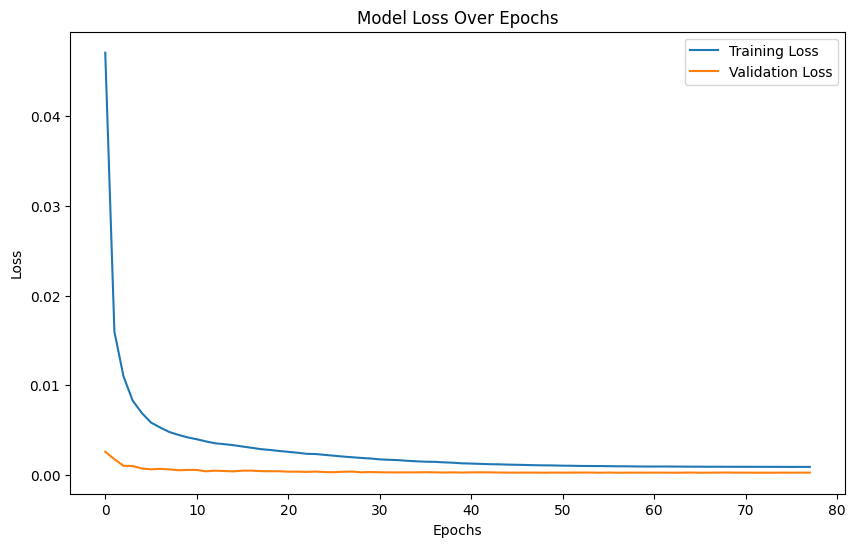

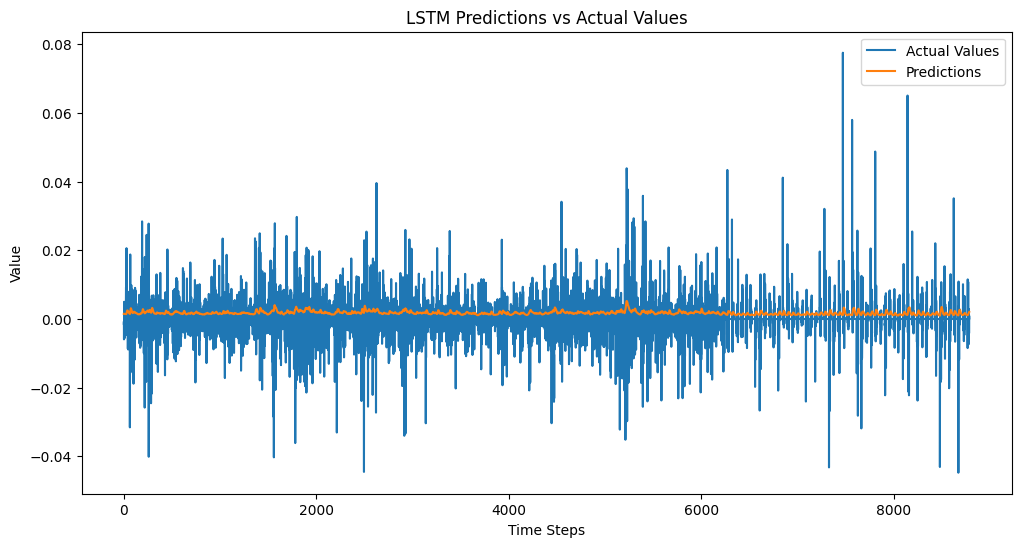

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('lstm_wl.keras')  
predictions = model.predict(X_test, batch_size=best_lstm_params['batch_size'])
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)





results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.001 else (-1 if x < -0.001 else 0))
stat_signal_result_df['target'] = df["target"]-1

stat_signal_result_df

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


,Actual,Predicted,signal,target
2024-01-01 00:00:00,-0.001385,0.001499,1,-1
2024-01-01 01:00:00,-0.000729,0.001486,1,0
2024-01-01 02:00:00,-0.005929,0.001478,1,-1
2024-01-01 03:00:00,0.000095,0.001462,1,0
2024-01-01 04:00:00,0.005017,0.001479,1,1
...,...,...,...,...
2024-12-31 19:00:00,-0.006308,0.001920,1,-1
2024-12-31 20:00:00,0.002858,0.001966,1,1
2024-12-31 21:00:00,-0.004142,0.002006,1,-1
2024-12-31 22:00:00,0.000933,0.002030,1,0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']



accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")


print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) 

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.3260
Precision (Weighted): 0.3547
Recall (Weighted): 0.3260
F1 Score (Weighted): 0.1606
\nMetrics per class:
  Class -1:
    Precision: 0.0000
    Recall:    0.0000
    F1 Score:  0.0000
  Class 0:
    Precision: 0.6667
    Recall:    0.0006
    F1 Score:  0.0012
  Class 1:
    Precision: 0.3259
    Recall:    1.0000
    F1 Score:  0.4916


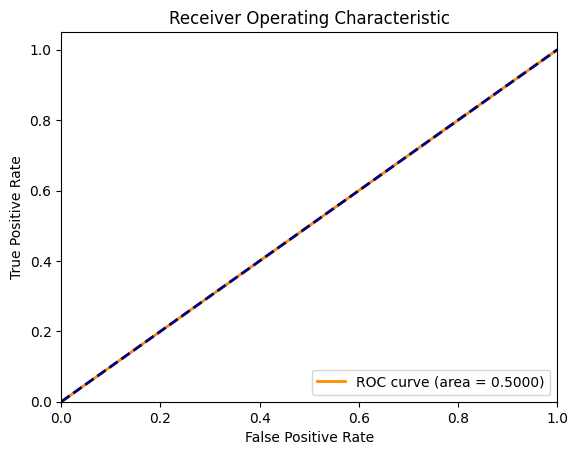

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score



mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]



y_true_binary = np.where(y_true_filtered == 1, 1, 0)


fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)


roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: 119.89%
Overall Annual Sharpe Ratio: 1.7575
Maximum Drawdown: -32.33 %
Alpha: -0.0036
Beta: 0.9999

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.198885     0.52758     0.999935     -0.003606       1.757497


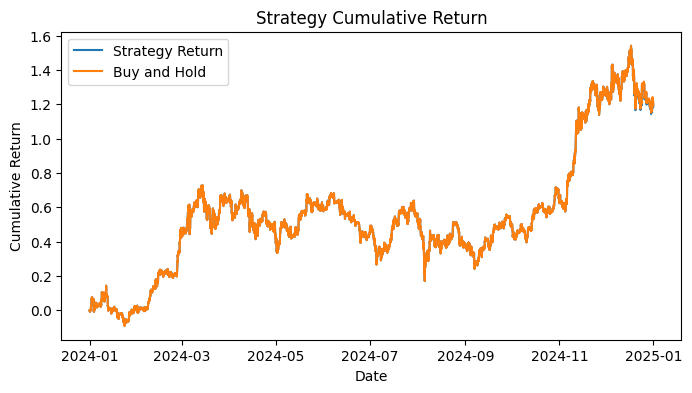

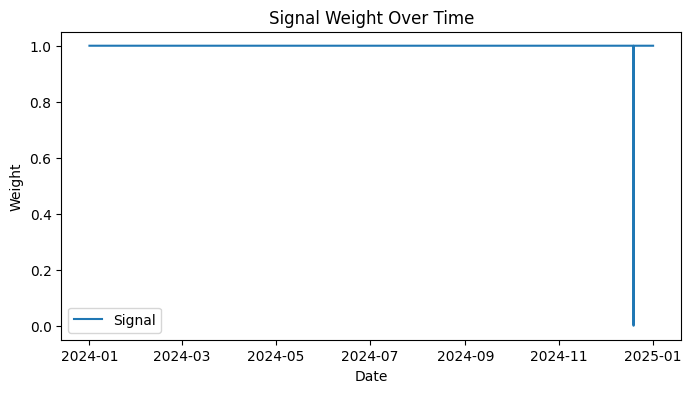

In [44]:
run_backtest(stat_signal_result_df, name ="LSTM_WL_Hybrid")